In [2]:
import os
import pickle
from collections import defaultdict
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def parse_results(directory, length_param_grid):
    
    files = [x for x in os.listdir(directory) if 'results' in x and '.txt.txt' not in x]

    results_dict = defaultdict(lambda:0)
    number_runs = defaultdict(lambda:0)
    all_params = []

    for file in files:
        param = int(file.split('_')[-2][1:])
        run_number = int(file.split('_')[-1].split('.')[0][1:])

        with open(directory+file, 'rb') as f:
            result = pickle.load(f)

        results_dict[param] += sum(result['presence_VR'])
        number_runs[param] += 10

        all_params.append((param, run_number))

    results_dict = dict(results_dict)
    
    # check that all runs are present
    missing = set(product(range(length_param_grid), range(100))).symmetric_difference(set(all_params))
    if len(missing) == 0:
        print('All runs have been parsed')
    else:
        print('Some runs are missing:', missing)
    
    percentage_takeover = dict(zip(list(results_dict.keys()), [results_dict[p]/number_runs[p] for p in list(results_dict.keys())]))
    confidence_intervals =  dict(zip(list(results_dict.keys()),[1.96*np.sqrt((percentage_takeover[p]*(1-percentage_takeover[p]))/1000) for p in list(results_dict.keys())]))
    
    return(percentage_takeover, confidence_intervals)

In [4]:
def get_index(df, desired_dict):

    subdf = df.copy()

    for keyval in desired_dict:
        if keyval in subdf.columns:
            subdf = subdf[subdf[keyval] == desired_dict[keyval]]
        
    # check that index unique
    if len(list(subdf.index)) != 1:
        print('Index not unique')
        
    return(subdf.index[0])

def get_paramgrid(file):
    with open(file, 'rb') as f:
        paramgrid = pickle.load(f)
    df = pd.DataFrame(paramgrid)  
    return(df)

In [5]:
basic_results, basic_ci = parse_results('bar_chart/basic_model/', 72)
diffimmun_results, diffimmun_ci = parse_results('bar_chart/different_immunities/', 18)

All runs have been parsed
All runs have been parsed


In [6]:
df_basic, df_diffimmun = get_paramgrid('bar_chart/basic_model/paramgrid_appearance_barchart_basic.txt'),get_paramgrid('bar_chart/different_immunities/paramgrid_appearance_barchart_different_immunities.txt')

In [7]:
q = 0.4
delta = 1
mu = 1e-7
f = 1

combs_cl = [(100,1000),(100,10000),(500,1000),(500,10000)]

In [8]:
all_simulations = ['basic', 'different_immunities']

all_results = dict(zip(all_simulations, [basic_results, diffimmun_results]))
all_ci = dict(zip(all_simulations, [basic_ci, diffimmun_ci]))
dfs = dict(zip(all_simulations, [df_basic, df_diffimmun]))

In [9]:
all_bar_results = [] 
all_bar_ci = [] 

for L, c in combs_cl:
    bar_results = defaultdict(list)
    bar_ci = defaultdict(list)
    desired_dict = {'delta':delta, 'mu':mu, 'q':q, 'c':c, 'i_threshold':L}

    for sim in all_simulations:
        bar_results[sim] = all_results[sim][get_index(dfs[sim], desired_dict)]
        bar_ci[sim] = all_ci[sim][get_index(dfs[sim], desired_dict)]


    all_bar_results.append(list(bar_results.values()))
    all_bar_ci.append(list(bar_ci.values()))

In [10]:
all_labels = ['Basic model', 'Different Partial Immunities for Recovered/Vaccinated']

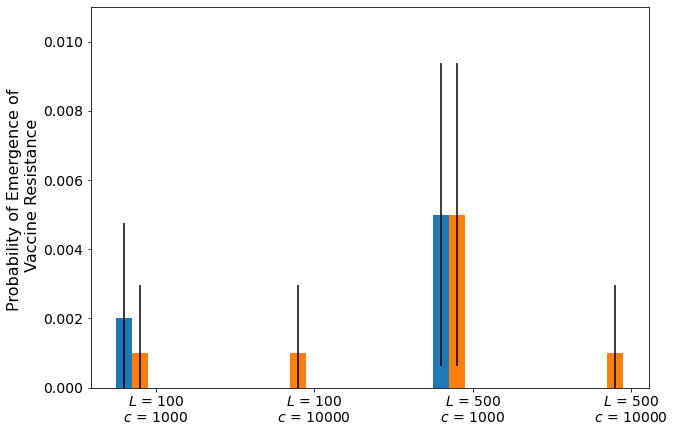

In [14]:
x = np.arange(0,4.,1)  # the label locations
width = 0.1  # the width of the bars
pos = np.arange(0,3.,0.5)

fig, ax = plt.subplots(figsize = (10,7))

for n in range(2):
    bars = ax.bar(x + pos[n]*width*2, np.array(all_bar_results)[:,n], width, yerr = np.array(all_bar_ci)[:,n], label=all_labels[n])
    

ax.set_ylabel('Probability of Emergence of \n Vaccine Resistance', fontsize = 16)
ax.set_xticks(x+0.2)
ax.set_xticklabels(['$L$ = ' + str(x[0]) + '\n$c$ = ' + str(x[1])  for x in combs_cl], fontsize = 14)
#ax.legend(fontsize = 14, bbox_to_anchor = (1.8,1.))
ax.set_ylim(0.,0.011)
ax.tick_params(labelsize = '14')
plt.savefig('Fig_SEP6_different_immunities_mu7.jpg', dpi=400)

In [38]:
1737/1.5

1158.0

In [39]:
50000/1158

43.17789291882556